# Import Module

In [21]:
import keras
from keras import applications
#from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D

from keras.preprocessing.image import ImageDataGenerator

# Load VGG19 Model

In [13]:
img_width, img_height = 256, 256

In [14]:
model = applications.VGG19(weights = "imagenet", 
                           include_top=False, 
                           input_shape = (img_width, img_height, 3)
                          )

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

###### parameter:
* weight: None (random initialization) or 'imagenet' (pre-training on ImageNet)
* input_shape: optional shape tuple, only to be specified if include_top is False (otherwise the input shape has to be (224, 224, 3))
* include_top: whether to include the 3 fully-connected layers at the top of the network.


# Modify Model

In [15]:
#Freeze the layers which you don't want to train. Here I am freezing the first 5 layers.
for layer in model.layers[:5]:
    layer.trainable = False

In [16]:
#Adding custom Layers 
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)

predictions = Dense(16, activation="softmax")(x)
#creating the final model

model_final = Model(inputs = model.input, outputs = predictions)

model_final.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [17]:
# compile the model 
model_final.compile(loss = "categorical_crossentropy", 
                    optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), 
                    metrics=["accuracy"])


# Data Preparation

In [26]:
train_data_dir = "labs02/data/train"
validation_data_dir = "labs02/data/val"
nb_train_samples = 4125
nb_validation_samples = 466 
batch_size = 16
epochs = 10
learning_rate = 0.0001
decay = 1e-6

In [24]:
# Initiate the train and test generators with data Augumentation 
train_datagen = ImageDataGenerator(rescale = 1./255)
    #horizontal_flip = True,
    #fill_mode = "nearest",
    #zoom_range = 0.3,
    #width_shift_range = 0.3,
    #height_shift_range=0.3,
    #rotation_range=30)

test_datagen = ImageDataGenerator(rescale = 1./255)
    #horizontal_flip = True,
    #fill_mode = "nearest",
    #zoom_range = 0.3,
    #width_shift_range = 0.3,
    #height_shift_range=0.3,
    #rotation_range=30)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = "categorical")

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size = (img_height, img_width),
    class_mode = "categorical")


Found 1516 images belonging to 16 classes.
Found 262 images belonging to 16 classes.


# Train Model

In [28]:
import os
import datetime
import time



# initiate RMSprop optimizer
#opt = keras.optimizers.rmsprop(lr=learning_rate, decay=decay)

# Let's train the model using RMSprop
#model.compile(loss='categorical_crossentropy',
#              optimizer=opt,
#              metrics=['accuracy'])

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

start = time.time()
history = model_final.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs
                    )

now = datetime.datetime.now()
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'labs01_model_{batch}.h5'.format(batch=now.strftime("%Y%m%d_%H%M"))

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

end = time.time()
print("Model took {:2.0f} seconds to train".format((end - start)))

Epoch 1/10
94/94 [==============================] - 8498s 90s/step - loss: 1.8673 - acc: 0.4785 - val_loss: 0.8773 - val_acc: 0.7748
Epoch 2/10
94/94 [==============================] - 12827s 136s/step - loss: 0.9716 - acc: 0.7112 - val_loss: 0.3531 - val_acc: 0.8969
Epoch 3/10
94/94 [==============================] - 7289s 78s/step - loss: 0.4729 - acc: 0.8526 - val_loss: 0.1993 - val_acc: 0.9275
Epoch 4/10
94/94 [==============================] - 7295s 78s/step - loss: 0.2608 - acc: 0.9182 - val_loss: 0.1215 - val_acc: 0.9618
Epoch 5/10
94/94 [==============================] - 7288s 78s/step - loss: 0.1335 - acc: 0.9599 - val_loss: 0.1438 - val_acc: 0.9542
Epoch 6/10
94/94 [==============================] - 7294s 78s/step - loss: 0.0911 - acc: 0.9727 - val_loss: 0.1299 - val_acc: 0.9580
Epoch 7/10
94/94 [==============================] - 7289s 78s/step - loss: 0.0606 - acc: 0.9801 - val_loss: 0.0775 - val_acc: 0.9656
Epoch 8/10
94/94 [==============================] - 7316s 78s/step 

In [29]:
from matplotlib import pyplot
def plot_model_history(model_history):
    # summarize history for accuracy
    pyplot.plot(history.history['acc'])
    pyplot.plot(history.history['val_acc'])
    pyplot.title('model accuracy')
    pyplot.ylabel('accuracy')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'test'], loc='upper left')
    pyplot.show()
    
    # summarize history for loss
    pyplot.plot(history.history['loss'])
    pyplot.plot(history.history['val_loss'])
    pyplot.title('model loss')
    pyplot.ylabel('loss')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'test'], loc='upper left')
    pyplot.show()
    

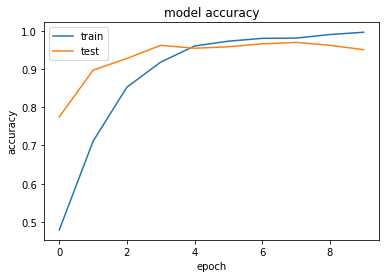

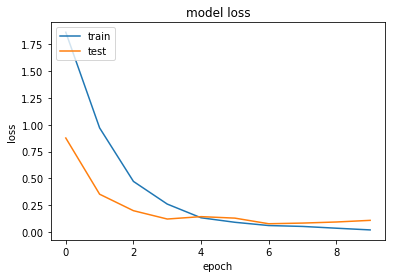

In [30]:
#show graph
plot_model_history(history)

# Save Model To JSON

In [35]:
from keras.models import model_from_json

save_dir = os.path.join(os.getcwd(), 'saved_models')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
    
model_name = 'labs02_model.json'
model_path = os.path.join(save_dir, model_name)

model_json = model.to_json()
with open(model_path, "w") as json_file:
    json_file.write(model_json)

weight_name = 'labs02_model_weight.h5'
wight_path = os.path.join(save_dir, weight_name)
model.save_weights(wight_path)

# Load JSON Model

In [ ]:
# load json and create model
json_file = open(model_path, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))